In [1]:
%pylab qt
%matplotlib qt
import numpy as np
import scipy
import pylab
import cv2
import PIL
from PIL import Image


import matplotlib.pyplot as plt
from align_image_code import align_images
from scipy.ndimage import gaussian_filter
from scipy import misc
from scipy import ndimage
from scipy.sparse import csr_matrix
from scipy import signal

%matplotlib inline

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if '.DS_Store' not in filename and '.ds_store' not in filename:
            img = skio.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
    return images

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

Populating the interactive namespace from numpy and matplotlib


In [5]:
"""
Part 2.2 Poisson Blending (30 pts)
"""

target = Image.open('data/im_background.jpg')
src = Image.open('data/im_s.jpg')
src_mask = Image.open('data/mask_s.jpg')

target = np.average(np.array(target, dtype=np.float), axis=2)
src = np.average(np.array(src, dtype=np.float), axis=2)
src_mask = np.array(src_mask, dtype=np.float)
flipped_mask = 1-src_mask

print (target.shape, src.shape, src_mask.shape)
[imh, imw] = target.shape
im2var = np.zeros((imh, imw))

val = 0
for i in range(im2var.shape[0]):
    for j in range(im2var.shape[1]):
        im2var[i,j] = val
        val += 1
        
laplacian = np.array([
        [0,-1,0],
        [-1,4,-1],
        [0,-1,0]
    ])
mask_indices = np.argwhere(src_mask > 0)


target_gradient = signal.convolve2d(target*flipped_mask, laplacian, 'valid') 
src_gradient = signal.convolve2d(src*src_mask, laplacian, 'valid') 
b = np.ravel(target_gradient + src_gradient)
A = np.identity(imh*imw)
for mi in range(mask_indices.shape[0]):
    pair = mask_indices[mi]
    i = pair[0]
    j = pair[1]
    currvar = int(im2var[i,j])
    A[currvar, currvar] = 4
    if i > 0:
        A[currvar, int(im2var[i-1,j])] = -1
    if i < target.shape[0]-1:
        A[currvar, int(im2var[i+1,j])] = -1
    if j > 0:
        A[currvar, int(im2var[i,j-1])] = -1
    if j < target.shape[1]-1:
        A[currvar, int(im2var[i,j+1])] = -1




[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]
((1408, 1056), (1408, 1056), (1408, 1056))


2159.56699122


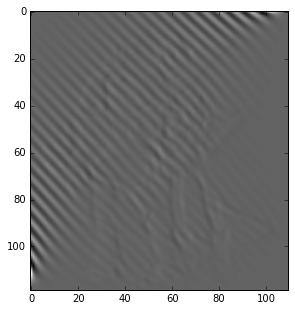

In [3]:
"""
Part 2: Gradient Domain Fushion
Part 2.1 Toy Problem (10 pts)
"""
def solver_input(img, A, b, orig_pixel= (0,0)):
    n=img.shape[0]*img.shape[1]
    rowA = 0
    
    vert_grad = np.gradient(img, axis=0)
    horiz_grad = np.gradient(img, axis=1)
    b[:imh*imw] = np.ravel(horiz_grad)
    b[imh*imw:b.shape[0]-1] = np.ravel(vert_grad)
    # do not include gradients for pixels that don't have gradients (like edge of img)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if x < img.shape[0] -1:
                A[rowA,int(im2var[ x+1,y ])] = 1
                A[rowA,int(im2var[ x,y ])] = -1
            if y< img.shape[1] -1:
                A[rowA,int(im2var[ x,y+1 ])] = 1
                A[rowA, int(im2var[ x, y ])] = -1
            rowA += 1
            
    A[rowA,int(im2var[orig_pixel[0], orig_pixel[1]])] =  img[orig_pixel[0],orig_pixel[1]]
    b[rowA] = img[orig_pixel[0],orig_pixel[1]]

im1 = Image.open('data/toy_problem.png')
im1 = np.array(im1, dtype=np.float)

[imh, imw] = im1.shape
im2var = np.zeros((imh, imw))

val = 0
for i in range(im2var.shape[0]):
    for j in range(im2var.shape[1]):
        im2var[i,j] = val
        val += 1

A = np.zeros((2*im1.shape[0]*im1.shape[1]+1, im1.shape[0]*im1.shape[1]))
b = np.zeros(2*im1.shape[0]*im1.shape[1]+1)

solver_input(im1, A, b)
A = scipy.sparse.csr_matrix(A)
rv = scipy.sparse.linalg.lsqr(A, b)
error = rv[3]
v = rv[0]
img = v.reshape(im1.shape)
plt.figure(figsize=(5,5))
# plt.imshow(PIL.Image.fromarray(img))
plt.imshow(img, cmap='gray')
plt.show

print error

((300, 300, 3), (300, 300, 3), (300, 300))
('naive', (300, 300, 3))
(0.72983390444738916, 255.0)
(13.037250086777682, 242.62902331675474)
(0.0, 139.37553703536889)
(0, 255)


<function matplotlib.pyplot.show>

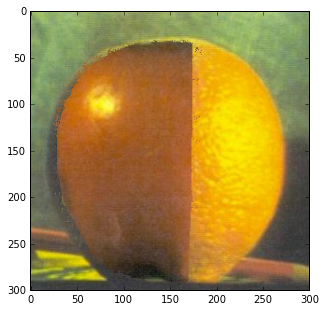

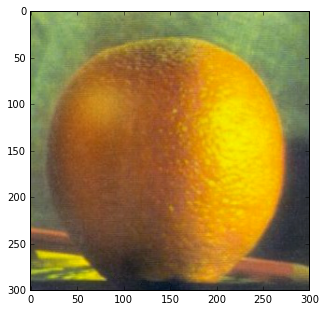

In [125]:
"""
Part 1.4: Multiresolution Blending (a.k.a. the oraple!) WITH COLOR

"""

def naive_multires_hybrid(im1, im2, mask, color=False):
    if color is True:
        color_channels = []
        for i in range(im1.shape[2]):
            color_channels.append(mask*im1[:,:,i] + (1-mask)*im2[:,:,i])
        return np.dstack(color_channels).astype('uint8')
    return mask*im1 + (1-mask)*im2

def blend_channel(l1, l2, m, gaussian_b):
    im = np.zeros(m[0].shape)
    for i in range(len(m)):
        im += m[i]*l1[i] + (1-m[i])*l2[i]
    im += gaussian_b[len(gaussian_b)-1]
    im *= 255.0/blend.max()
    np.clip(im, 0, 1)
    return im

def multires_hybrid(l1, l2, m, gaussian_b, color=False):
    if color is True:
        color_channels = []
        for i in range(len(l1)):
            color_channel = blend_channel(l1[i], l2[i], m, gaussian_b[i])
            color_channel = np.clip(color_channel, 0, 255)
            print (color_channel.min(), color_channel.max())
            color_channels.append(color_channel)
        im = np.dstack(color_channels).astype('uint8')
        return im
        
    return blend_channel(l1, l2, m, gaussian_b)

def pyramids(im, sigma, curr_level, levels):
    if curr_level == levels:
        return [], []
    low_passed  = gaussian_filter(im, sigma*curr_level)
    high_passed = im - low_passed

    gaussian, laplacian = pyramids(low_passed, sigma, curr_level+1, levels)
    return [im] + gaussian, [high_passed] + laplacian
    # or was it [low_passed] + gaussian
    
def graph(gaussian, laplacian, n, color=False):
    # row and column sharing
    rows = 2
    cols = n

    f, axarr = plt.subplots(2, n, figsize=(20,10))

    if color is True:
        return None # TODO
    else:
        for c in range(cols):
            axarr[0, c].imshow(PIL.Image.fromarray(gaussian[c]))
            axarr[1, c].imshow(PIL.Image.fromarray(laplacian[c]*255))
        plt.show()


# high sf
im1 = Image.open('data/spline/apple.jpg')
im1 = np.array(im1, dtype=float)

im2 = Image.open('data/spline/orange.jpg')
im2 = np.array(im2, dtype=float)

im3 = Image.open('data/spline/orange_mask.jpg')
im3 = np.average(np.array(im3, dtype=float), axis=2)
im3[im3 > 0] = 1

print (im1.shape, im2.shape, im3.shape)
# Compute and display Gaussian and Laplacian Pyramids
# You also need to supply this function
N = 6 # suggested number of pyramid levels (your choice)
sigma = 2
gaussian1 = [[] for i in range(im1.shape[2])]
laplacian1 = [[] for i in range(im1.shape[2])]
gaussian2 = [[] for i in range(im1.shape[2])]
laplacian2 = [[] for i in range(im1.shape[2])]
gaussian_b = [[] for i in range(im1.shape[2])]
laplacian_b = [[] for i in range(im1.shape[2])]

gaussian_m, laplacian_m = pyramids(im3, sigma, 1, N+1)
naive_blend = naive_multires_hybrid(im1, im2, im3, color=True)
print ('naive', naive_blend.shape)
for i in range(im1.shape[2]):
    gaussian1[i], laplacian1[i] = pyramids(im1[:,:,i], sigma, 1, N+1)
    gaussian2[i], laplacian2[i] = pyramids(im2[:,:,i], sigma, 1, N+1)
    gaussian_b[i], laplacian_b[i] = pyramids(naive_blend[:,:,i], sigma, 1, N+1)

plt.figure(figsize=(5,5))
plt.imshow(PIL.Image.fromarray(naive_blend))
plt.show

blend = multires_hybrid(laplacian1, laplacian2, laplacian_m, gaussian_b, color=True)

print (blend.min(), blend.max())
plt.figure(figsize=(5,5))
plt.imshow(blend)
plt.show


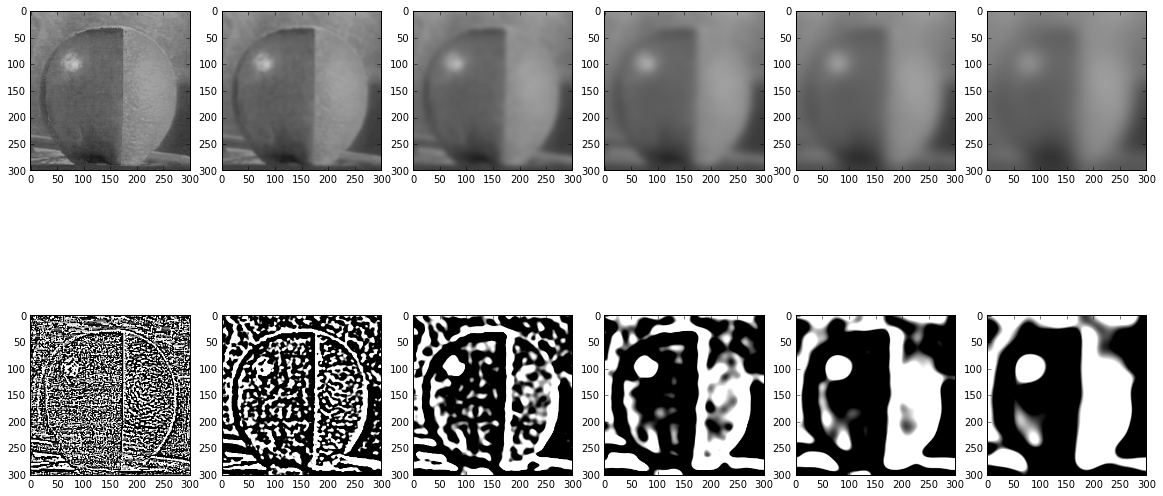

<function matplotlib.pyplot.show>

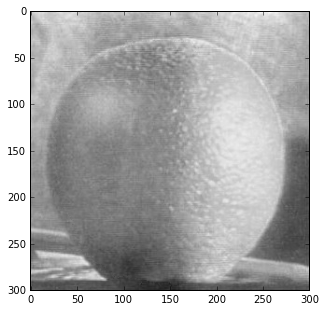

In [79]:
"""
Part 1.4: Multiresolution Blending (a.k.a. the oraple!)

To get the final blended result, I summed the 6 images in the Laplacian stack for the blended image 
and the last image in the Gaussian stack for the naively blended image (σ = 32). 
This operation gets me my final result. We can see that the edges of the Jeep blend in nicely with the components of the Macbook. The image gives the impression that the Jeep is driving out of the screen of the Macbook.



"""

def naive_multires_hybrid(im1, im2, mask):
    return mask*im1 + (1-mask)*im2

def multires_hybrid(l1, l2, m):
    im = np.zeros(m[0].shape)
    for i in range(len(m)):
        im += m[i]*l1[i] + (1-m[i])*l2[i]
    return im

def pyramids(im, sigma, curr_level, levels):
    if curr_level == levels:
        return [], []
    low_passed  = gaussian_filter(im, sigma*curr_level)
    high_passed = im - low_passed

    gaussian, laplacian = pyramids(low_passed, sigma, curr_level+1, levels)
    return [im] + gaussian, [high_passed] + laplacian
    # or was it [low_passed] + gaussian
    
def graph(gaussian, laplacian, n):
    # row and column sharing
    rows = 2
    cols = n

    f, axarr = plt.subplots(2, n, figsize=(20,10))

    for c in range(cols):
        axarr[0, c].imshow(PIL.Image.fromarray(gaussian[c]))
        axarr[1, c].imshow(PIL.Image.fromarray(laplacian[c]*255))
    plt.show()


# high sf
im1 = Image.open('data/spline/apple.jpg')#.convert('LA')
im1 = np.average(np.array(im1, dtype=float), axis=2)

im2 = Image.open('data/spline/orange.jpg')#.convert('LA')
im2 = np.average(np.array(im2, dtype=float), axis=2)

im3 = Image.open('data/spline/orange_mask.jpg')#.convert('LA')
im3 = np.average(np.array(im3, dtype=float), axis=2)
im3[im3 > 0] = 1

# Compute and display Gaussian and Laplacian Pyramids
# You also need to supply this function
N = 6 # suggested number of pyramid levels (your choice)
sigma = 2
gaussian1, laplacian1 = pyramids(im1, sigma, 1, N+1)
gaussian2, laplacian2 = pyramids(im2, sigma, 1, N+1)
gaussian_m, laplacian_m = pyramids(im3, sigma, 1, N+1)

# graph(gaussian1, laplacian1, N)
# graph(gaussian2, laplacian2, N)
# graph(gaussian_m, laplacian_m, N)

# sigma1 = 7
# sigma2 = 1.7

naive_blend = naive_multires_hybrid(im1, im2, im3)
gaussian_b, laplacian_b = pyramids(naive_blend, sigma, 1, N+1)
graph(gaussian_b, laplacian_b, N)

blend = multires_hybrid(laplacian1, laplacian2, laplacian_m)
blend += gaussian_b[len(gaussian_b)-1]
blend *= 255.0/blend.max()
np.clip(blend, 0, 1)

plt.figure(figsize=(5,5))
plt.imshow(PIL.Image.fromarray(blend))
plt.show


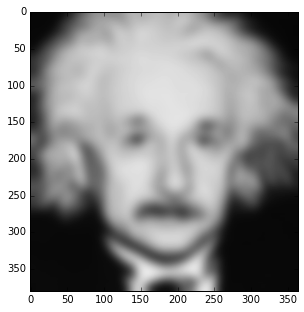

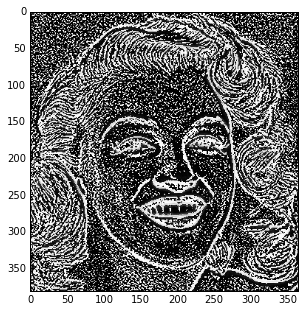

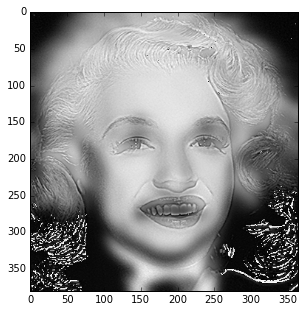

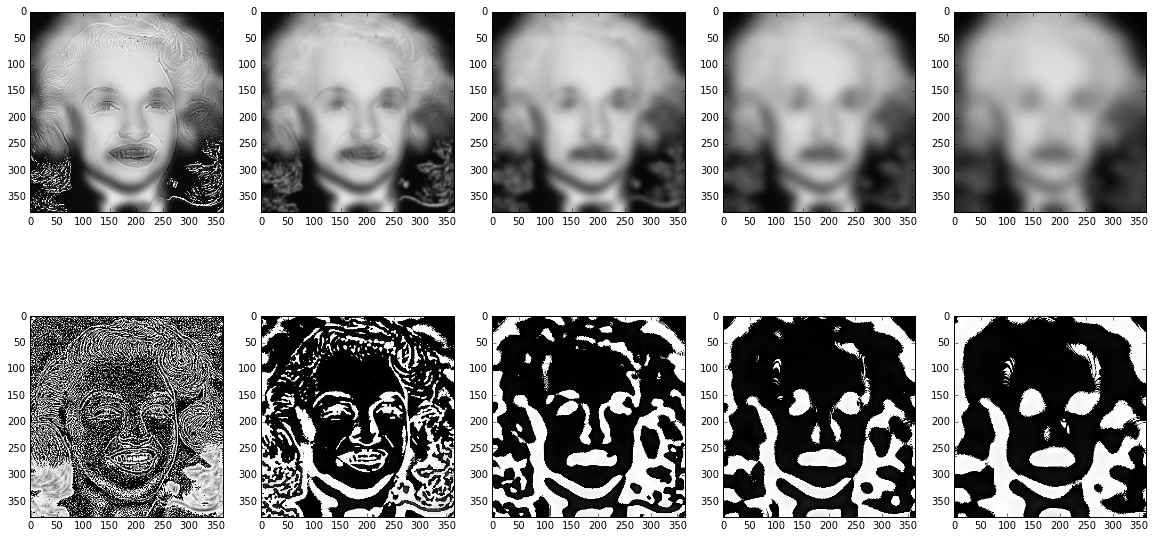

In [29]:
"""
Part 1.3: Gaussian and Laplacian Stacks
In this part you will implement Gaussian and Laplacian stacks, 
which are kind of like pyramids but without the downsampling. 
Then you will use these to analyze some images, and your results from part 1.2.
"""
def hybrid_image(im1, im2, sigma1, sigma2):
    low_passed = ndimage.gaussian_filter(im1, sigma1)
    high_passed = im2 - ndimage.gaussian_filter(im2, sigma2)
    return low_passed, high_passed, low_passed + high_passed

def pyramids(im, sigma, curr_level, levels):
    if curr_level == levels:
        return [], []
    low_passed  = gaussian_filter(im, sigma*curr_level)
    high_passed = im - low_passed
    
    gaussian, laplacian = pyramids(low_passed, sigma, curr_level+1, levels)
    return [im] + gaussian, [high_passed] + laplacian
    # or was it [low_passed] + gaussian

# high sf
im1 = Image.open('data/einstein.png')#.convert('LA')
#im1 = np.average(np.array(im1, dtype=float), axis=2)
# low sf
im2 = Image.open('data/marilyn.png')#.convert('LA')
#im2 = np.average(np.array(im2, dtype=float), axis=2)

sigma1 = 7
sigma2 = 1.7

im1_filtered, im2_filtered, hybrid = hybrid_image(im1, im2, sigma1, sigma2)

plt.figure(figsize=(5,5))
plt.imshow(im1_filtered)
plt.show

plt.figure(figsize=(5,5))
plt.imshow(im2_filtered)
plt.show

plt.figure(figsize=(5,5))
plt.imshow(hybrid)
plt.show

## Compute and display Gaussian and Laplacian Pyramids
## You also need to supply this function
N = 5 # suggested number of pyramid levels (your choice)
sigma = 2
gaussian, laplacian = pyramids(hybrid, sigma, 1, N+1)

# row and column sharing
rows = 2
cols = N

f, axarr = plt.subplots(2, N, figsize=(20,10))

for c in range(cols):
    axarr[0, c].imshow(gaussian[c])
    axarr[1, c].imshow(laplacian[c])
plt.show()



<function matplotlib.pyplot.show>

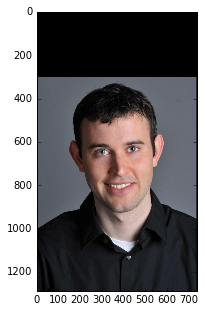

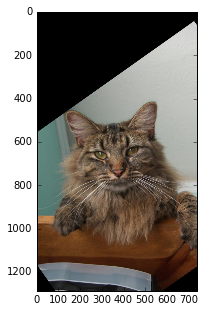

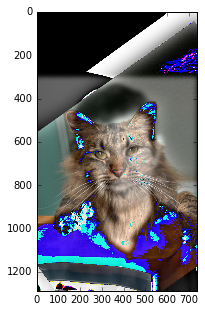

In [102]:
"""
Part 1.2: Hybrid Images
EVERYTHING IS SO BROKEN
NOTE: cutoff frequency means (mean - sigma, mean + sigma) of gaussian
Need to do with gray AND color
"""
def hybrid_image(im1, im2, sigma1, sigma2):
    low_passed = gaussian_filter(im1, sigma1)
    high_passed = im2 - gaussian_filter(im2, sigma2)
#     low_passed = im1*gaussian_filter(im1, sigma1)
#     high_passed = im2 * (1- gaussian_filter(im2, sigma2))
    return low_passed + high_passed

# high sf
im1 = Image.open('data/aligned/DerekPicture.jpg')#.convert('LA')

# low sf
im2 = Image.open('data/aligned/nutmeg.jpg')#.convert('LA')

plt.figure(figsize=(5,5))
plt.imshow(im1)
plt.show

plt.figure(figsize=(5,5))
plt.imshow(im2)
plt.show

## You will provide the code below. Sigma1 and sigma2 are arbitrary 
## cutoff values for the high and low frequencies
# 10, 40
sigma1 = 10
sigma2 = 40

hybrid = hybrid_image(im1, im2, sigma1, sigma2)

plt.figure(figsize=(5,5))
plt.imshow(hybrid)
plt.show

# ## Compute and display Gaussian and Laplacian Pyramids
# ## You also need to supply this function
# N = 5 # suggested number of pyramid levels (your choice)
# # pyramids(hybrid, N)

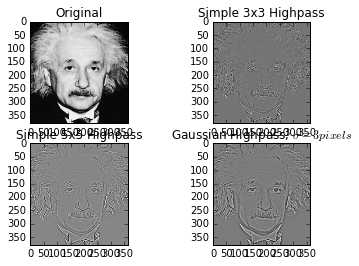

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from PIL import Image

def plot(data, title):
    plot.i += 1
    plt.subplot(2,2,plot.i)
    plt.imshow(data)
    plt.gray()
    plt.title(title)
plot.i = 0

# Load the data...
im = Image.open('data/einstein.png')
data = np.average(np.array(im, dtype=float), axis=2)
plot(data, 'Original')

# A very simple and very narrow highpass filter
kernel = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]])
highpass_3x3 = ndimage.convolve(data, kernel)
plot(highpass_3x3, 'Simple 3x3 Highpass')

# A slightly "wider", but sill very simple highpass filter 
kernel = np.array([[-1, -1, -1, -1, -1],
                   [-1,  1,  2,  1, -1],
                   [-1,  2,  4,  2, -1],
                   [-1,  1,  2,  1, -1],
                   [-1, -1, -1, -1, -1]])
highpass_5x5 = ndimage.convolve(data, kernel)
plot(highpass_5x5, 'Simple 5x5 Highpass')

# Another way of making a highpass filter is to simply subtract a lowpass
# filtered image from the original. Here, we'll use a simple gaussian filter
# to "blur" (i.e. a lowpass filter) the original.
lowpass = ndimage.gaussian_filter(data, 3)
gauss_highpass = data - lowpass
plot(gauss_highpass, r'Gaussian Highpass, $\sigma = 3 pixels$')

plt.show()

<function matplotlib.pyplot.show>

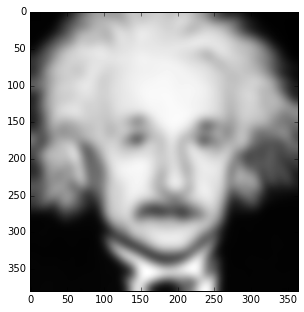

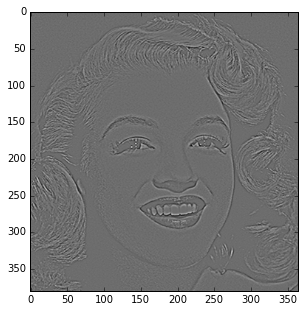

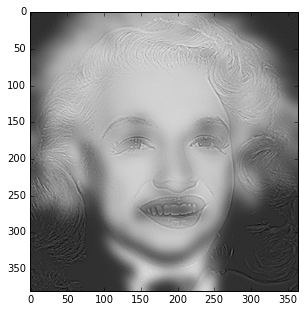

In [15]:
# WORKS A LOT BETTER WITH GRAY IMAGES
def hybrid_image(im1, im2, sigma1, sigma2):
    low_passed = ndimage.gaussian_filter(im1, sigma1)
    high_passed = im2 - ndimage.gaussian_filter(im2, sigma2)
    return low_passed, high_passed, low_passed + high_passed

# high sf
im1 = Image.open('data/einstein.png')#.convert('LA')
im1 = np.average(np.array(im1, dtype=float), axis=2)
# low sf
im2 = Image.open('data/marilyn.png')#.convert('LA')
im2 = np.average(np.array(im2, dtype=float), axis=2)
## You will provide the code below. Sigma1 and sigma2 are arbitrary 
## cutoff values for the high and low frequencies

sigma1 = 7
sigma2 = 1.3

im1_filtered, im2_filtered, hybrid = hybrid_image(im1, im2, sigma1, sigma2)

plt.figure(figsize=(5,5))
plt.imshow(im1_filtered)
plt.show

plt.figure(figsize=(5,5))
plt.imshow(im2_filtered)
plt.show

plt.figure(figsize=(5,5))
plt.imshow(hybrid)
plt.show

# ## Compute and display Gaussian and Laplacian Pyramids
# ## You also need to supply this function
# N = 5 # suggested number of pyramid levels (your choice)
# # pyramids(hybrid, N)

# plt.figure(figsize=(5,5))
# plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(im1_filtered)))))
# plt.show
# plt.figure(figsize=(5,5))
# plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(im2_filtered)))))
# plt.show

# plt.figure(figsize=(5,5))
# plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(hybrid)))))
# plt.show

<function matplotlib.pyplot.show>

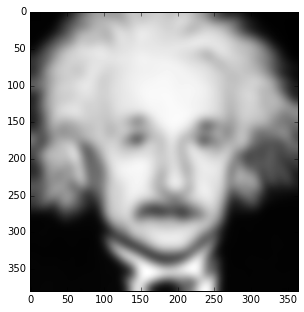

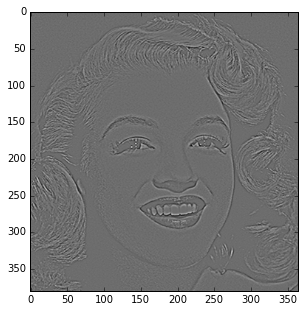

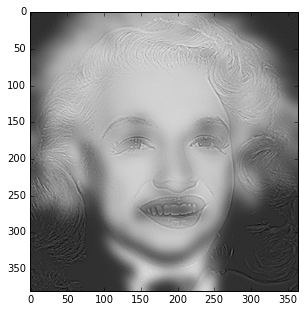

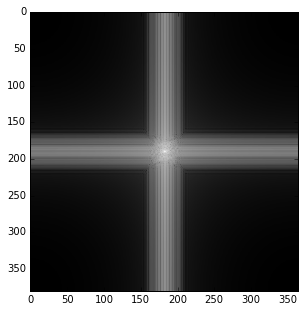

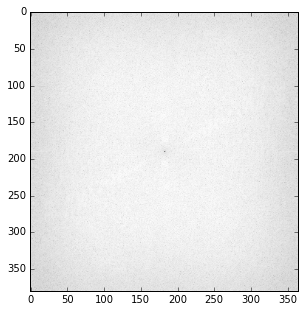

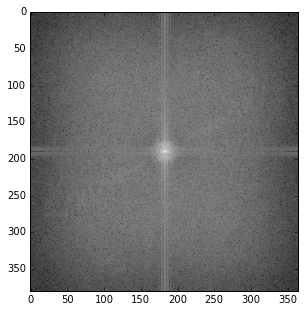

In [16]:
# WORKS A LOT BETTER WITH GRAY IMAGES
def hybrid_image(im1, im2, sigma1, sigma2):
    low_passed = ndimage.gaussian_filter(im1, sigma1)
    high_passed = im2 - ndimage.gaussian_filter(im2, sigma2)
    return low_passed, high_passed, low_passed + high_passed

# high sf
im1 = Image.open('data/einstein.png')#.convert('LA')
im1 = np.average(np.array(im1, dtype=float), axis=2)
# low sf
im2 = Image.open('data/marilyn.png')#.convert('LA')
im2 = np.average(np.array(im2, dtype=float), axis=2)
## You will provide the code below. Sigma1 and sigma2 are arbitrary 
## cutoff values for the high and low frequencies

sigma1 = 7
sigma2 = 1.3

im1_filtered, im2_filtered, hybrid = hybrid_image(im1, im2, sigma1, sigma2)

plt.figure(figsize=(5,5))
plt.imshow(im1_filtered)
plt.show

plt.figure(figsize=(5,5))
plt.imshow(im2_filtered)
plt.show

plt.figure(figsize=(5,5))
plt.imshow(hybrid)
plt.show

## Compute and display Gaussian and Laplacian Pyramids
## You also need to supply this function
N = 5 # suggested number of pyramid levels (your choice)
# pyramids(hybrid, N)

plt.figure(figsize=(5,5))
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(im1_filtered)))))
plt.show
plt.figure(figsize=(5,5))
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(im2_filtered)))))
plt.show

plt.figure(figsize=(5,5))
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(hybrid)))))
plt.show



<function matplotlib.pyplot.show>

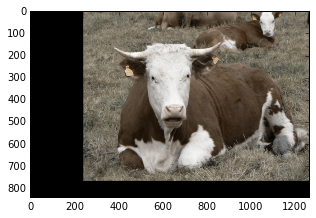

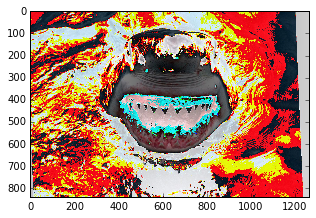

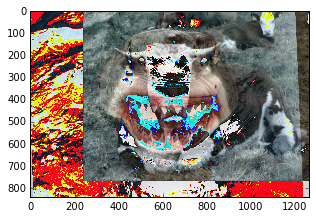

In [116]:
# image supposed to be gray!!
def hybrid_image(im1, im2, sigma1, sigma2):
    low_passed = gaussian_filter(im1, sigma1)
    high_passed = im2 - gaussian_filter(im2, sigma2)
    return low_passed, high_passed, low_passed + high_passed

# high sf
im1 = Image.open('data/aligned/cow.jpg')#.convert('LA')

# low sf
im2 = Image.open('data/aligned/shark.jpg')#.convert('LA')

# plt.figure(figsize=(5,5))
# plt.imshow(im1)
# plt.show
# plt.figure(figsize=(5,5))
# plt.imshow(im2)
# plt.show

## You will provide the code below. Sigma1 and sigma2 are arbitrary 
## cutoff values for the high and low frequencies

sigma1 = 1
sigma2 = 100

im1_filtered, im2_filtered, hybrid = hybrid_image(im1, im2, sigma1, sigma2)

plt.figure(figsize=(5,5))
plt.imshow(im1_filtered)
plt.show

plt.figure(figsize=(5,5))
plt.imshow(im2_filtered)
plt.show

plt.figure(figsize=(5,5))
plt.imshow(hybrid)
plt.show

# ## Compute and display Gaussian and Laplacian Pyramids
# ## You also need to supply this function
# N = 5 # suggested number of pyramid levels (your choice)
# # pyramids(hybrid, N)

# plt.figure(figsize=(5,5))
# plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(im1_filtered)))))
# plt.show
# plt.figure(figsize=(5,5))
# plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(im2_filtered)))))
# plt.show

# plt.figure(figsize=(5,5))
# plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(hybrid)))))
# plt.show

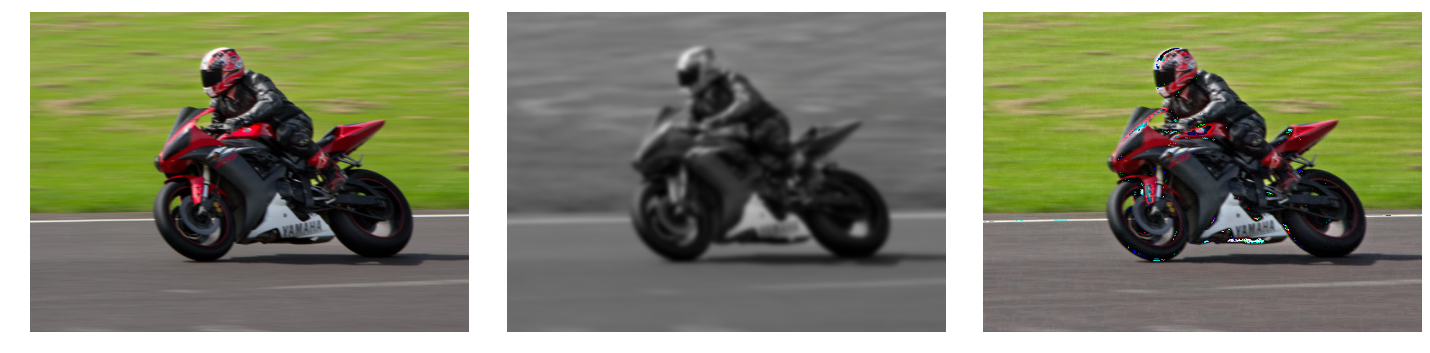

In [36]:
"""
Part 1: Frequency Domain
1.1 Warmup: Pick your favorite blurry image and "sharpen" it using the unsharp masking technique we covered in class.
"""
im1 = plt.imread('data/motorcycle.jpg')

blurred = gaussian_filter(im1, 3)

filter_blurred = gaussian_filter(blurred, 1)

alpha = 5
sharpened = im1 + alpha * (blurred - filter_blurred)

plt.figure(figsize=(20,10))

plt.subplot(131)
plt.imshow(im1, cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(132)
plt.imshow(blurred, cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(133)
plt.imshow(sharpened, cmap=plt.cm.gray)
plt.axis('off')

plt.tight_layout()
plt.show()